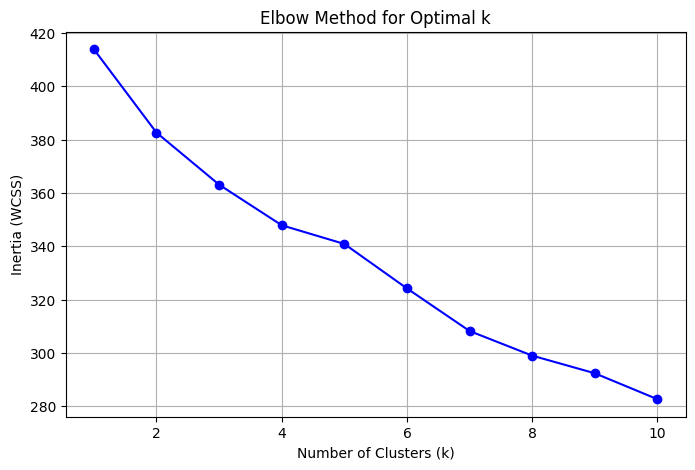

In [101]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np

# Load data
df = pd.read_csv("/content/drive/MyDrive/SET SEMINAR/new/org_topics_with_metadata - Sayfa1 (1).csv")

# Preprocess 'languages' and 'topics'
df['languages'] = df['languages'].fillna('').apply(lambda x: [i.strip() for i in str(x).split(',') if i])
df['topics'] = df['topics'].fillna('').apply(lambda x: [i.strip() for i in str(x).split(',') if i])

# One-hot encode
mlb_lang = MultiLabelBinarizer()
mlb_topic = MultiLabelBinarizer()
lang_df = pd.DataFrame(mlb_lang.fit_transform(df["languages"]), columns=[f"lang_{c}" for c in mlb_lang.classes_])
topic_df = pd.DataFrame(mlb_topic.fit_transform(df["topics"]), columns=[f"topic_{c}" for c in mlb_topic.classes_])
features = pd.concat([lang_df, topic_df], axis=1)

inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


AI Policy distribution per cluster:
AI Policy       Allowed  Have Guideline    Hybrid  Not Allowed  Not Mention
final_cluster                                                              
0              0.285714        0.142857  0.071429     0.071429     0.428571
1              0.181818        0.045455  0.000000     0.045455     0.727273
2              0.133333        0.066667  0.000000     0.066667     0.733333


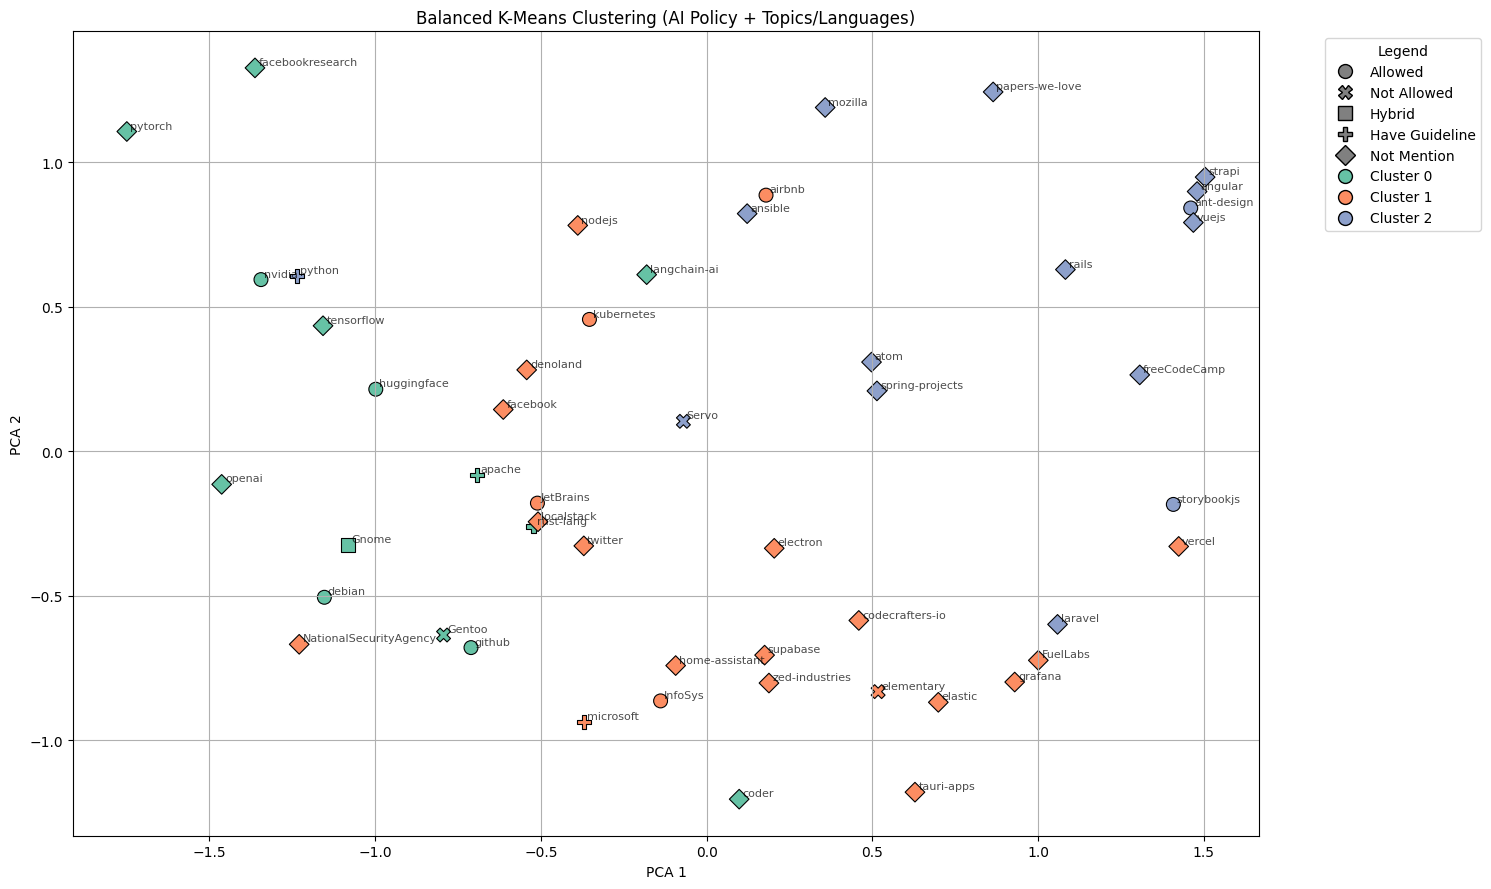

In [91]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np

# Load data
df = pd.read_csv("/content/drive/MyDrive/SET SEMINAR/new/org_topics_with_metadata - Sayfa1 (1).csv")

# Preprocess 'languages' and 'topics'
df['languages'] = df['languages'].fillna('').apply(lambda x: [i.strip() for i in str(x).split(',') if i])
df['topics'] = df['topics'].fillna('').apply(lambda x: [i.strip() for i in str(x).split(',') if i])

# One-hot encode
mlb_lang = MultiLabelBinarizer()
mlb_topic = MultiLabelBinarizer()
lang_df = pd.DataFrame(mlb_lang.fit_transform(df["languages"]), columns=[f"lang_{c}" for c in mlb_lang.classes_])
topic_df = pd.DataFrame(mlb_topic.fit_transform(df["topics"]), columns=[f"topic_{c}" for c in mlb_topic.classes_])
features = pd.concat([lang_df, topic_df], axis=1)

# --- Step 1: Split data by AI Policy for balanced clustering ---
clusters = 3
df["kmeans_cluster"] = -1

for policy in df['AI Policy'].unique():
    policy_indices = df[df['AI Policy'] == policy].index
    if len(policy_indices) > clusters:
        # Apply K-Means only to this policy group
        kmeans = KMeans(n_clusters=clusters, random_state=42, n_init=10)
        policy_clusters = kmeans.fit_predict(features.loc[policy_indices])
        df.loc[policy_indices, "kmeans_cluster"] = policy_clusters
    else:
        # If too few samples, assign to existing clusters in a round-robin fashion
        df.loc[policy_indices, "kmeans_cluster"] = np.arange(len(policy_indices)) % clusters

# --- Step 2: Merge clusters while keeping AI Policy balanced ---
# Now, we have clusters per policy. We need to merge them into global clusters.
final_clusters = np.zeros(len(df), dtype=int)
cluster_offset = 0

for cluster in range(clusters):
    for policy in df['AI Policy'].unique():
        policy_cluster_indices = df[(df['AI Policy'] == policy) & (df['kmeans_cluster'] == cluster)].index
        final_clusters[policy_cluster_indices] = cluster_offset
    cluster_offset += 1

df["final_cluster"] = final_clusters

# --- Step 3: Verify AI Policy Distribution ---
print("\nAI Policy distribution per cluster:")
print(pd.crosstab(df["final_cluster"], df["AI Policy"], normalize='index'))

# --- Step 4: Visualize Clusters (PCA) ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)
df["pca1"] = pca_result[:, 0]
df["pca2"] = pca_result[:, 1]

marker_styles = {
    "Allowed": "o",
    "Not Allowed": "X",
    "Hybrid": "s",
    "Have Guideline": "P",
    "Not Mention": "D"
}

plt.figure(figsize=(15, 9))
for policy, marker in marker_styles.items():
    subset = df[df["AI Policy"] == policy]
    sns.scatterplot(
        data=subset,
        x="pca1",
        y="pca2",
        hue="final_cluster",
        palette="Set2",
        style="AI Policy",
        markers=marker_styles,
        s=100,
        marker=marker,
        edgecolor="black",
        legend=False
    )
    for _, row in subset.iterrows():
        plt.text(row["pca1"] + 0.01, row["pca2"] + 0.01, row["org"], fontsize=8, alpha=0.7)

# Custom legends
from matplotlib.lines import Line2D
ai_legend = [Line2D([0], [0], marker=marker_styles[p], color='w', label=p,
                    markerfacecolor='gray', markersize=10, markeredgecolor='black')
             for p in marker_styles]

cluster_legend = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {c}',
                         markerfacecolor=col, markersize=10, markeredgecolor='black')
                  for c, col in zip(sorted(df['final_cluster'].unique()),
                                   sns.color_palette('Set2', n_colors=clusters))]

plt.legend(handles=ai_legend + cluster_legend, title="Legend", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Balanced K-Means Clustering (AI Policy + Topics/Languages)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Step 5: Export Results ---
df_export = df[["org", "AI Policy", "languages", "topics", "final_cluster"]]
df_export.to_csv("/content/drive/MyDrive/SET SEMINAR/new/Clustered_Orgs.csv", index=False)

In [93]:
import pandas as pd
from ast import literal_eval
from collections import Counter

# Load clustered orgs file
clustered_orgs_path = "/content/drive/MyDrive/SET SEMINAR/new/Clustered_Orgs.csv"
df_clusters = pd.read_csv(clustered_orgs_path)

# Convert stringified lists to actual Python lists
df_clusters['languages'] = df_clusters['languages'].apply(literal_eval)
df_clusters['topics'] = df_clusters['topics'].apply(literal_eval)

# Initialize dicts
cluster_top_langs = {}
cluster_top_topics = {}

# Process each cluster
for cluster_id, group in df_clusters.groupby("final_cluster"):
    # Top languages
    all_languages = [lang for sublist in group["languages"] for lang in sublist]
    top_5_langs = [lang for lang, _ in Counter(all_languages).most_common(5)]
    cluster_top_langs[cluster_id] = top_5_langs

    # Top topics
    all_topics = [topic for sublist in group["topics"] for topic in sublist]
    top_5_topics = [topic for topic, _ in Counter(all_topics).most_common(5)]
    cluster_top_topics[cluster_id] = top_5_topics


# Outpu
cluster_top_langs

{0: ['C++', 'Python', 'C', 'Jupyter Notebook', 'HTML'],
 1: ['TypeScript', 'JavaScript', 'Python', 'C', 'Java'],
 2: ['JavaScript', 'HTML', 'CSS', 'TypeScript', 'SCSS']}

In [104]:
import pandas as pd
from ast import literal_eval
from collections import Counter

# Load clustered orgs file
clustered_orgs_path = "/content/drive/MyDrive/SET SEMINAR/new/Clustered_Orgs.csv"
data = pd.read_csv(clustered_orgs_path)

# Helper function to parse stringified lists
def parse_list(text):
    try:
        if pd.isna(text):
            return []
        return literal_eval(text)
    except Exception as e:
        print(f"Failed parsing: {text} -> {e}")
        return []

# Initialize a dictionary to store results
clusters_summary = {}

# Loop through clusters and summarize languages and topics
for cluster in sorted(data['final_cluster'].unique()):
    cluster_data = data[data['final_cluster'] == cluster]

    # Count languages
    languages_counter = Counter()
    for lang_list in cluster_data['languages']:
        parsed_langs = parse_list(lang_list)
        languages_counter.update(parsed_langs)

    # Count topics
    topics_counter = Counter()
    for topic_list in cluster_data['topics']:
        parsed_topics = parse_list(topic_list)
        topics_counter.update(parsed_topics)

    # Store results
    clusters_summary[cluster] = {
        'top_languages': languages_counter.most_common(6),
        'top_topics': topics_counter.most_common(6)
    }

# Optional: print summary for review
for cluster, summary in clusters_summary.items():
    print(f"\nCluster {cluster}")
    print("Top Languages:", summary['top_languages'])
    print("Top Topics:", summary['top_topics'])
cluster_top_langs = {
    cluster: [lang for lang, _ in summary['top_languages']]
    for cluster, summary in clusters_summary.items()
}
cluster_top_langs


Cluster 0
Top Languages: [('C++', 11), ('Python', 10), ('C', 9), ('Jupyter Notebook', 7), ('HTML', 5), ('TypeScript', 4)]
Top Topics: [('deep-learning', 5), ('pytorch', 4), ('machine-learning', 4), ('python', 3), ('neural-network', 2), ('hacktoberfest', 2)]

Cluster 1
Top Languages: [('TypeScript', 14), ('JavaScript', 14), ('Python', 13), ('C', 10), ('Java', 8), ('C++', 8)]
Top Topics: [('hacktoberfest', 6), ('javascript', 5), ('java', 3), ('python', 2), ('rust', 2), ('database', 2)]

Cluster 2
Top Languages: [('JavaScript', 14), ('HTML', 12), ('CSS', 10), ('TypeScript', 7), ('SCSS', 3), ('Python', 3)]
Top Topics: [('javascript', 4), ('nodejs', 2), ('framework', 2), ('python', 2), ('react', 2), ('strapi', 1)]


{np.int64(0): ['C++', 'Python', 'C', 'Jupyter Notebook', 'HTML', 'TypeScript'],
 np.int64(1): ['TypeScript', 'JavaScript', 'Python', 'C', 'Java', 'C++'],
 np.int64(2): ['JavaScript', 'HTML', 'CSS', 'TypeScript', 'SCSS', 'Python']}

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os

# === CONFIG ===
BASE_PATH = "/content/drive/MyDrive/SET SEMINAR/new/"
CLUSTER_FILE = os.path.join(BASE_PATH, "Clustered_Orgs.csv")
INTERVENTION_DATE = pd.to_datetime("2022-01-01")
RESULTS_OUTPUT = os.path.join(BASE_PATH, "its_summary_results.csv")

# === LOAD CLUSTER INFO ===
df_clusters = pd.read_csv(CLUSTER_FILE)
ai_policy_map = {
    "Allowed": "LLM_Positive",
    "Hybrid": "LLM_Negative",
    "Not Allowed": "LLM_Negative",
    "Not Mention": "Not Mention",
    "Have Guideline": "LLM_Positive",
}
df_clusters["PolicyGroup"] = df_clusters["AI Policy"].map(ai_policy_map)

# === DEFINE TOP LANGUAGES PER CLUSTER ===


# === ITS ANALYSIS FUNCTION ===
def run_its_analysis(data, language, policy_group, cluster_id, results_list):
    data["month"] = data["created_at"].dt.to_period("M")
    lang_repos = data[data["language"] == language].groupby("month").size().rename("lang_repos")
    total_repos = data.groupby("month").size().rename("total_repos")

    df = pd.concat([lang_repos, total_repos], axis=1).fillna(0)
    df.index = df.index.to_timestamp()
    df = df.reindex(pd.date_range(start=df.index.min(), end=df.index.max(), freq="MS"), fill_value=0)
    df.index.name = "month"
    df = df.reset_index()

    df["time"] = np.arange(len(df))
    df["llm"] = (df["month"] >= INTERVENTION_DATE).astype(int)
    df["time_after_llm"] = df.apply(
        lambda row: row["time"] - df[df["llm"] == 1]["time"].min() if row["llm"] == 1 else 0,
        axis=1
    )
    df["lang_ratio"] = df["lang_repos"] / (df["total_repos"] + 1e-6)
    df["lang_ratio"] = df["lang_ratio"].rolling(window=3, center=True, min_periods=1).mean()

    X = df[["time", "llm", "time_after_llm"]]
    X = sm.add_constant(X)
    y = df["lang_ratio"]

    try:
        model = sm.OLS(y, X).fit()
        results_list.append({
            "cluster": cluster_id,
            "language": language,
            "policy_group": policy_group,
            "intercept": model.params["const"],
            "trend_before": model.params["time"],
            "level_change": model.params["llm"],
            "slope_change": model.params["time_after_llm"],
            "p_level": model.pvalues["llm"],
            "p_slope": model.pvalues["time_after_llm"],
            "r_squared": model.rsquared
        })
    except:
        print(f"[Skipped] ITS failed for Cluster {cluster_id}, {policy_group}, {language}")

# === MAIN AGGREGATION PIPELINE ===
its_results = []

for cluster_id in [0, 1, 2]:
    top_langs = cluster_top_langs[cluster_id]
    orgs_in_cluster = df_clusters[df_clusters["final_cluster"] == cluster_id]

    for policy_group in ["LLM_Positive", "LLM_Negative", "Not Mention"]:
        orgs = orgs_in_cluster[orgs_in_cluster["PolicyGroup"] == policy_group]["org"]

        org_dataframes = []
        for org in orgs:
            file_path = os.path.join(BASE_PATH, f"{org}_repos.csv")
            if os.path.exists(file_path):
                try:
                    df_org = pd.read_csv(file_path, parse_dates=["created_at"])
                    df_org["org"] = org
                    org_dataframes.append(df_org)
                except:
                    print(f"[Error] Reading file for {org}")
            else:
                print(f"[Missing] {file_path}")

        if not org_dataframes:
            continue

        df_meta = pd.concat(org_dataframes, ignore_index=True)

        for lang in top_langs:
            run_its_analysis(df_meta.copy(), lang, policy_group, cluster_id, its_results)

# === SAVE RESULTS ===
df_results = pd.DataFrame(its_results)
df_results.to_csv(RESULTS_OUTPUT, index=False)
print(f"\n✅ ITS summary results saved to: {RESULTS_OUTPUT}")
display(df_results.head())

/tmp/ipython-input-99-1890669849.py:29: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data["month"] = data["created_at"].dt.to_period("M")
/tmp/ipython-input-99-1890669849.py:29: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data["month"] = data["created_at"].dt.to_period("M")
/tmp/ipython-input-99-1890669849.py:29: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data["month"] = data["created_at"].dt.to_period("M")
/tmp/ipython-input-99-1890669849.py:29: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data["month"] = data["created_at"].dt.to_period("M")
/tmp/ipython-input-99-1890669849.py:29: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data["month"] = data["created_at"].dt.to_period("M")
/tmp/ipython-input-99-1890669849.py:29: UserWarning: Converting t


✅ ITS summary results saved to: /content/drive/MyDrive/SET SEMINAR/new/its_summary_results.csv


,cluster,language,policy_group,intercept,trend_before,level_change,slope_change,p_level,p_slope,r_squared
0,0,C++,LLM_Positive,0.005788,0.000324,-0.036857,0.000816,0.015150,0.141016,0.119943
1,0,Python,LLM_Positive,-0.005141,0.000784,0.047644,0.001564,0.006533,0.014781,0.684492
2,0,C,LLM_Positive,0.105616,-0.000427,-0.000194,0.000160,0.995159,0.891317,0.066060
3,0,Jupyter Notebook,LLM_Positive,-0.006709,0.000155,0.017076,0.000640,0.003686,0.003005,0.592111
4,0,HTML,LLM_Positive,-0.010780,0.000593,-0.054445,-0.001029,0.000009,0.020093,0.355523


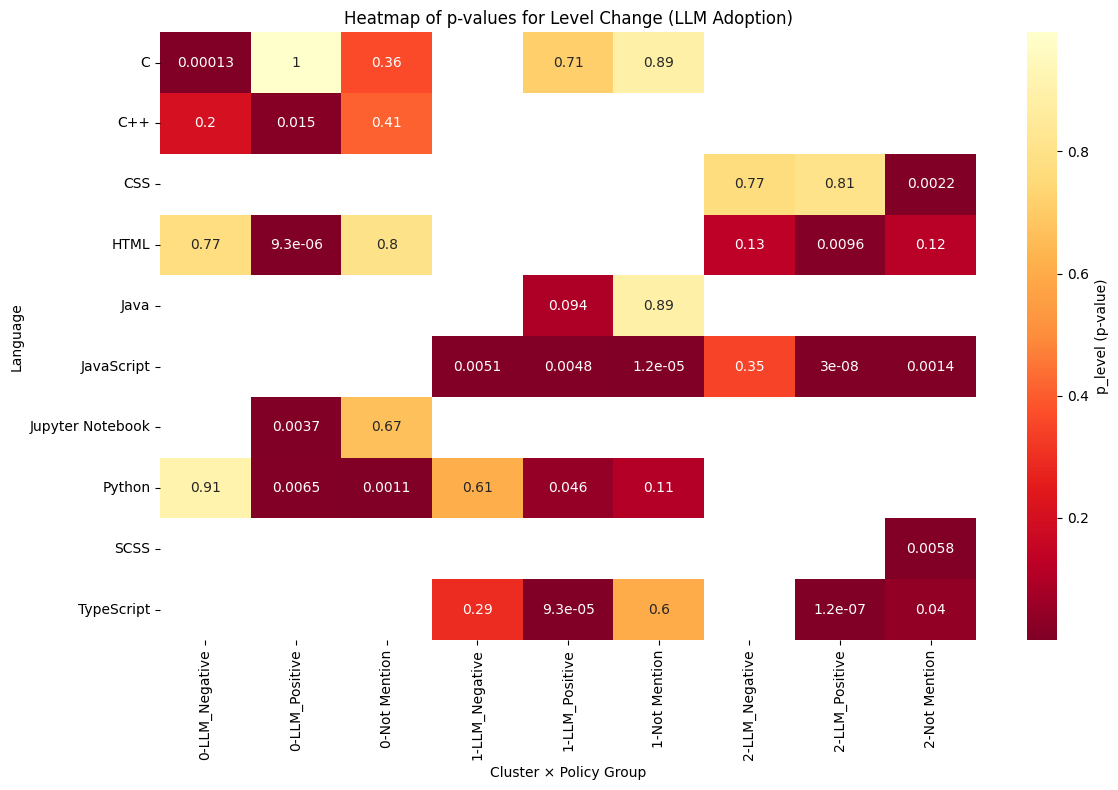

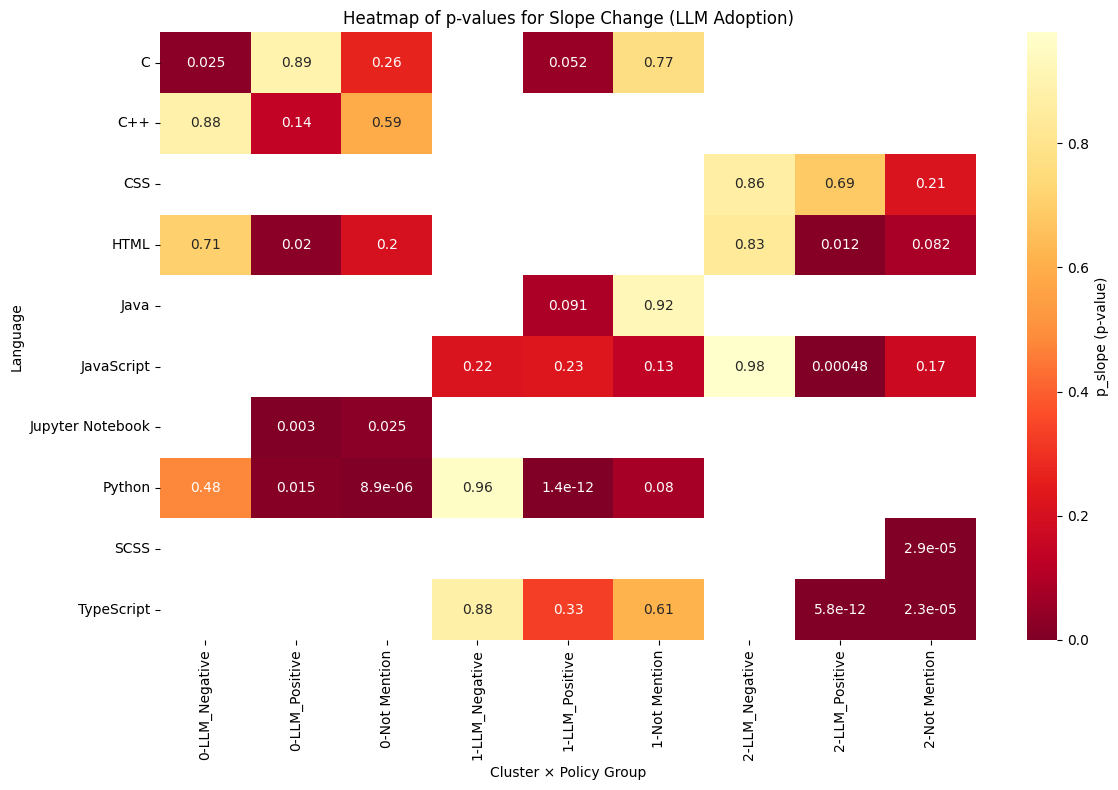

In [102]:
# Re-import necessary libraries due to kernel reset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Reload the ITS results CSV file
BASE_PATH = "/content/drive/MyDrive/SET SEMINAR/new"
CLUSTER_FILE = os.path.join(BASE_PATH, "Clustered_Orgs.csv")
INTERVENTION_DATE = pd.to_datetime("2022-01-01")
RESULTS_OUTPUT = os.path.join(BASE_PATH, "its_summary_results.csv")
file_path = "/content/drive/MyDrive/SET SEMINAR/new/its_summary_results.csv"
its_results_df = pd.read_csv(file_path)

# Convert p-values to numeric if needed
its_results_df['p_level'] = pd.to_numeric(its_results_df['p_level'], errors='coerce')
its_results_df['p_slope'] = pd.to_numeric(its_results_df['p_slope'], errors='coerce')

# Create a pivot table for heatmaps
def create_significance_heatmap(data, value_col, title, filename):
    pivot_df = data.pivot_table(
        index="language",
        columns=["cluster", "policy_group"],
        values=value_col,
        aggfunc="min"
    )

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        pivot_df,
        cmap="YlOrRd_r",  # Darker color = stronger significance
        annot=True,
        fmt=".2g",
        cbar_kws={"label": f"{value_col} (p-value)"}
    )
    plt.title(title)
    plt.ylabel("Language")
    plt.xlabel("Cluster × Policy Group")
    plt.tight_layout()
    plt.savefig(f"{BASE_PATH}/{filename}", dpi=300)  # Save as PNG
    plt.show()
create_significance_heatmap(its_results_df, "p_level", "Heatmap of p-values for Level Change (LLM Adoption)", "level_change_heatmap.png")
create_significance_heatmap(its_results_df, "p_slope", "Heatmap of p-values for Slope Change (LLM Adoption)", "slope_change_heatmap.png")


In [22]:
import requests
import pandas as pd
import os
import time

# === CONFIG ===
GITHUB_TOKEN = "your_token_here"  # Replace with your GitHub token
HEADERS = {'Authorization': f'token {""}'}
OUTPUT_DIR = "/content/drive/MyDrive/SET SEMINAR/new/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === LOAD ORGS ===
orgs_df = pd.read_csv("/content/drive/MyDrive/SET SEMINAR/new/Clustered_Orgs.csv")
org_names = orgs_df["org"].unique()

# === FETCH & SAVE PER ORG ===
for org in org_names:
    print(f"\nFetching repos for: {org}")
    org_repos = []
    page = 1
    per_page = 100
    max_repos = 2000

    while len(org_repos) < max_repos:
        url = f"https://api.github.com/orgs/{org}/repos?per_page={per_page}&page={page}&sort=created&direction=desc"
        response = requests.get(url, headers=HEADERS)

        if response.status_code != 200:
            print(f"[{org}] Failed to fetch (status {response.status_code})")
            break

        repos = response.json()
        if not repos:
            break

        for repo in repos:
            org_repos.append({
                "repo": repo.get("name"),
                "created_at": repo.get("created_at"),
                "language": repo.get("language"),
                "updated_at": repo.get("updated_at")
            })

            if len(org_repos) >= max_repos:
                break

        page += 1
        time.sleep(1)  # polite delay to avoid rate limits

    if org_repos:
        org_df = pd.DataFrame(org_repos)
        org_df["created_at"] = pd.to_datetime(org_df["created_at"])
        org_df["updated_at"] = pd.to_datetime(org_df["updated_at"])

        file_path = os.path.join(OUTPUT_DIR, f"{org}_repos.csv")
        org_df.to_csv(file_path, index=False)
        print(f"[{org}] Saved {len(org_repos)} repos to {file_path}")
    else:
        print(f"[{org}] No repos found.")


Fetching repos for: debian
[debian] Saved 128 repos to /content/drive/MyDrive/SET SEMINAR/new/debian_repos.csv

Fetching repos for: strapi
[strapi] Saved 80 repos to /content/drive/MyDrive/SET SEMINAR/new/strapi_repos.csv

Fetching repos for: kubernetes
[kubernetes] Saved 79 repos to /content/drive/MyDrive/SET SEMINAR/new/kubernetes_repos.csv

Fetching repos for: InfoSys
[InfoSys] Saved 80 repos to /content/drive/MyDrive/SET SEMINAR/new/InfoSys_repos.csv

Fetching repos for: zed-industries
[zed-industries] Saved 88 repos to /content/drive/MyDrive/SET SEMINAR/new/zed-industries_repos.csv

Fetching repos for: pytorch
[pytorch] Saved 82 repos to /content/drive/MyDrive/SET SEMINAR/new/pytorch_repos.csv

Fetching repos for: NationalSecurityAgency
[NationalSecurityAgency] Saved 85 repos to /content/drive/MyDrive/SET SEMINAR/new/NationalSecurityAgency_repos.csv

Fetching repos for: spring-projects
[spring-projects] Saved 85 repos to /content/drive/MyDrive/SET SEMINAR/new/spring-projects_repo